In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import spatial

In [3]:
# reference:   https://doi.org/10.1089/cmb.2006.13.745

def muller_brown_potential(x,y,perturb=None):  #perturb is a list [coeff_x,coeff_y]
    
    #define constants
    A=[-200,-100,-170,15];
    a=[-1,-1,-6.5,0.7];
    b=[0,0,11,0.6];
    c=[-10,-10,-6.5,0.7];
    
    x0=[1,0,-0.5,-1];
    y0=[0,0.5,1.5,1];
    
    #sum over k=1 to k=4
    z=0
    for k in range(4):
        z+=A[k]*np.exp( a[k]*(x-x0[k])**2 + b[k]*(x-x0[k])*(y-y0[k])+c[k]*(y-y0[k])**2)

    #introduce 1st order perturbation 
    if perturb != None:
        z+=perturb[0]*x+perturb[1]*y
    return z   

def muller_brown_force(x,y,perturb=None):
    
    #define constants
    A=[-200,-100,-170,15];
    a=[-1,-1,-6.5,0.7];
    b=[0,0,11,0.6];
    c=[-10,-10,-6.5,0.7];
    x0=[1,0,-0.5,-1];
    y0=[0,0.5,1.5,1];
    
    #sum over k=1 to k=4
    dudx=0; dudy=0
    for k in range(4):
        p=A[k]*np.exp( a[k]*(x-x0[k])**2 + b[k]*(x-x0[k])*(y-y0[k])+c[k]*(y-y0[k])**2)
        x_specific=2*a[k]*(x-x0[k])  +  b[k]*(y-y0[k])
        y_specific=b[k]*(x-x0[k]) + 2*c[k]*(y-y0[k])
        dudx+=p*x_specific
        dudy+=p*y_specific

    #introduce 1st order perturbation 
    if perturb != None:
        dudx+=perturb[0]
        dudy+=perturb[1]
        
    dudx=-1*dudx
    dudy=-1*dudy
    return dudx, dudy


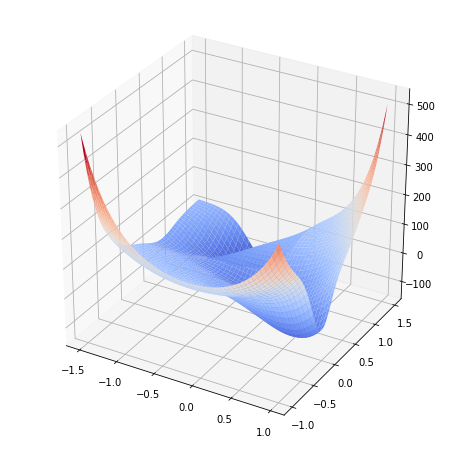

In [13]:
#plot unperturbed potential
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection="3d")

X=np.arange(-1.5,1,1/100)
Y=np.arange(-1,1.5,1/100)
X, Y = np.meshgrid(X, Y)
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y)))
Z = Z.reshape(X.shape)
ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)

In [3]:
#reference: https://doi.org/10.1080/00268978800101881

def propagate(x_n,y_n,x_n_1,y_n_1,dt,gamma=0.05,m=1,k=1,T=1,perturb=None):
    
    # potential
    energy=muller_brown_potential(x_n,y_n,perturb)
    
    # systematic and random forces 
    Fn=muller_brown_force(x_n,y_n,perturb)
    Fn_x=Fn[0]; Fn_y=Fn[1]
    Rn=np.random.normal(0,np.sqrt(2*m*gamma*k*T/dt))
    
    # update positions
    x_next=x_n+(x_n-x_n_1)*(1-0.5*gamma*dt)/(1+0.5*gamma*dt)+((dt**2)/m)*(Fn_x+Rn)/(1+0.5*gamma*dt)
    y_next=y_n+(y_n-y_n_1)*(1-0.5*gamma*dt)/(1+0.5*gamma*dt)+((dt**2)/m)*(Fn_y+Rn)/(1+0.5*gamma*dt)
    
    #update velocities 
    vx_next=(x_next-x_n_1)/(2*dt)
    vy_next=(y_next-y_n_1)/(2*dt)
    
    return x_next, y_next, energy

In [126]:
def simulate(perturb=None):
    x=[0,-0.05]
    y=[0,0.05]
    energy=[muller_brown_potential(x[0],y[0],perturb), muller_brown_potential(x[1],y[1],perturb)]
    nsteps=100000
    dt=0.001 
    time=nsteps*dt
    gamma=0.05/dt
    m=1
    k=1
    T=1
    nstep=1
    while nstep <= nsteps:
        progress=propagate(x[nstep],y[nstep],x[nstep-1],y[nstep-1],dt,gamma,m,k,T,perturb)
        x.append(progress[0])
        y.append(progress[1])
        energy.append(progress[-1])
        nstep+=1

    return x, y, energy



<Figure size 432x288 with 0 Axes>

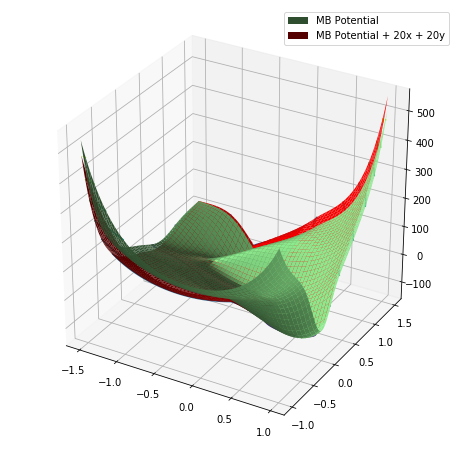

In [9]:
#plot potentials

plt.clf()

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection="3d")

X=np.arange(-1.5,1,1/100)
Y=np.arange(-1,1.5,1/100)
X, Y = np.meshgrid(X, Y)


# original 
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y)))
Z = Z.reshape(X.shape)
l1=ax.plot_surface(X,Y,Z,color="lightgreen",label="MB Potential")
ax.contour(X, Y, Z, 10, linestyles="solid")

# 20x+20y
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),[20,20]))
Z = Z.reshape(X.shape)
l2=ax.plot_surface(X,Y,Z,color="red", label="MB Potential + 20x + 20y")
ax.contour(X, Y, Z, 10, linestyles="solid")

# # 77x+77y
# Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),[77,77]))
# Z = Z.reshape(X.shape)
# l3=ax.plot_surface(X,Y,Z,color="c",label="MB Potential + 77x + 77y")
# ax.contour(X, Y, Z, 10, linestyles="solid")

# # 100x+100y
# Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),[100,100]))
# Z = Z.reshape(X.shape)
# l4=ax.plot_surface(X,Y,Z,color="cyan",label="MB Potential + 100x + 100y")
# ax.contour(X, Y, Z, 10, linestyles="solid")

l1._facecolors2d=l1._facecolors3d
l1._edgecolors2d=l1._edgecolors3d
l2._facecolors2d=l2._facecolors3d
l2._edgecolors2d=l2._edgecolors3d
# l3._facecolors2d=l3._facecolors3d
# l3._edgecolors2d=l3._edgecolors3d
# l4._facecolors2d=l4._facecolors3d
# l4._edgecolors2d=l4._edgecolors3d

ax.legend()

In [128]:
# simulate for different potentials 

simulation_original=simulate()
x_original=simulation_original[0]
y_original=simulation_original[1]
energy_original=simulation_original[2]

simulation_50=simulate([50,50])
x_50=simulation_50[0]
y_50=simulation_50[1]
energy_50=simulation_50[2]

simulation_77=simulate([77,77])
x_77=simulation_77[0]
y_77=simulation_77[1]
energy_77=simulation_77[2]

simulation_100=simulate([100,100])
x_100=simulation_100[0]
y_100=simulation_100[1]
energy_100=simulation_100[2]





<Figure size 432x288 with 0 Axes>

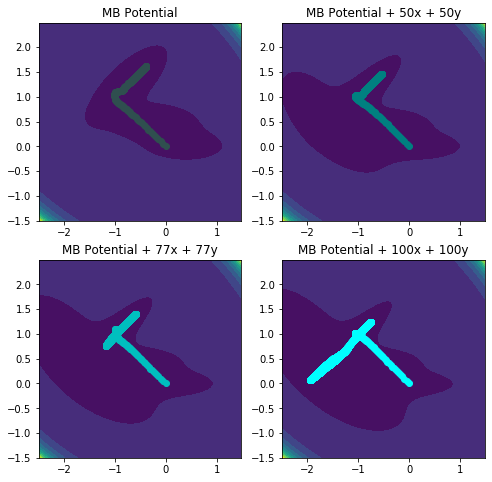

In [129]:
plt.clf()
fig=plt.figure(figsize=(8,8))
X=np.arange (-2.5,1.5,1/100)
Y=np.arange(-1.5,2.5,1/100)
X, Y = np.meshgrid(X, Y)



Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y)))
Z = Z.reshape(X.shape)
x_original=np.asarray(x_original)
y_original=np.asarray(y_original)
ax1=fig.add_subplot(221)
ax1.contourf(X, Y, Z, 10, linestyles="solid")
ax1.scatter(x_original,y_original,color="darkslategrey")
ax1.title.set_text("MB Potential")


Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),[50,50]))
Z = Z.reshape(X.shape)
x_50=np.asarray(x_50)
y_50=np.asarray(y_50)
ax2=fig.add_subplot(222)
ax2.contourf(X, Y, Z, 10, linestyles="solid")
ax2.scatter(x_50,y_50,color="teal")
ax2.title.set_text("MB Potential + 50x + 50y")


Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),[77,77]))
Z = Z.reshape(X.shape)
x_77=np.asarray(x_77)
y_77=np.asarray(y_77)
ax3=fig.add_subplot(223)
ax3.contourf(X, Y, Z, 10, linestyles="solid")
ax3.scatter(x_77,y_77,color="c")
ax3.title.set_text("MB Potential + 77x + 77y")



Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),[100,100]))
Z = Z.reshape(X.shape)
x_100=np.asarray(x_100)
y_100=np.asarray(y_100)
ax4=fig.add_subplot(224)
ax4.contourf(X, Y, Z, 10, linestyles="solid")
ax4.scatter(x_100,y_100,color="cyan")
ax4.title.set_text("MB Potential + 100x + 100y")



In [4]:
def simulate_short_trajectories(x_min_grid,x_max_grid,y_min_grid,y_max_grid,perturb=None):
    x=[np.random.uniform(x_min_grid,x_max_grid),np.random.uniform(x_min_grid,x_max_grid)]
    y=[np.random.uniform(y_min_grid,y_max_grid),np.random.uniform(y_min_grid,y_max_grid)]
   
    energy=[muller_brown_potential(x[0],y[0],perturb), muller_brown_potential(x[1],y[1],perturb)]
    
    nsteps=5
    dt=0.001 
    time=nsteps*dt
    gamma=0.05/dt
    m=1
    k=1
    T=1
    nstep=1
    while nstep <= nsteps:
        progress=propagate(x[nstep],y[nstep],x[nstep-1],y[nstep-1],dt,gamma,m,k,T,perturb)
        x.append(progress[0])
        y.append(progress[1])
        energy.append(progress[-1])
        nstep+=1

    return x,y, energy

Small Perturbation with 20x+20y on Muller-Brown Potential

<Figure size 432x288 with 0 Axes>

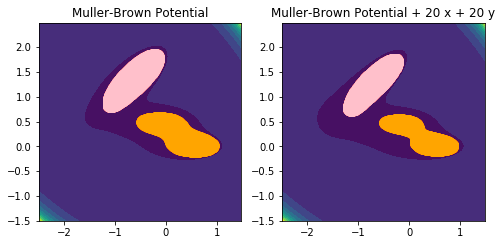

In [4]:


plt.clf()

fig=plt.figure(figsize=(8,8))
X=np.arange (-2.5,1.5,1/100)
Y=np.arange(-1.5,2.5,1/100)
x_new=X[:]; y_new=Y[:]
X, Y = np.meshgrid(X, Y)
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y)))
Z = Z.reshape(X.shape)
ax=fig.add_subplot(221)
ax.contourf(X, Y, Z, 10, linestyles="solid")
ax.set_title('Muller-Brown Potential')

z_index=np.where(Z<-60)
x_new=x_new[z_index[1]].ravel()
y_new=y_new[z_index[0]].ravel()
ax.scatter(x_new, y_new, c='r')

new=np.stack((x_new,y_new)).T
new_a=new[np.where(new[:,0]<0)]
new_a2=new_a[np.where(new_a[:,1]>new_a[:,0]+np.full(np.shape(new_a[:,0]),1.4))]

new_b=new[np.where(new[:,0]>-0.8)]
new_b2=new_b[np.where(new_b[:,1]<new_b[:,0]+np.full(np.shape(new_b[:,0]),1.4))]

#hull=spatial.ConvexHull(new_a2)
ax.scatter(new_a2[:,0], new_a2[:,1],c="pink")
ax.scatter(new_b2[:,0], new_b2[:,1],c="orange")






X=np.arange (-2.5,1.5,1/100)
Y=np.arange(-1.5,2.5,1/100)
x_new=X; y_new=Y
X, Y = np.meshgrid(X, Y)
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),perturb=[20,20]))
Z = Z.reshape(X.shape)
ax=fig.add_subplot(222)
ax.contourf(X, Y, Z, 10, linestyles="solid")
ax.set_title('Muller-Brown Potential + 20 x + 20 y')

z_index=np.where(Z<-60)
x_new=x_new[z_index[1]].ravel()
y_new=y_new[z_index[0]].ravel()
ax.scatter(x_new, y_new, c='r')

new=np.stack((x_new,y_new)).T
new_a=new[np.where(new[:,0]<0)]
new_a2=new_a[np.where(new_a[:,1]>new_a[:,0]+np.full(np.shape(new_a[:,0]),1.4))]

new_b=new[np.where(new[:,0]>-0.8)]
new_b2=new_b[np.where(new_b[:,1]<new_b[:,0]+np.full(np.shape(new_b[:,0]),1.4))]

ax.scatter(new_a2[:,0], new_a2[:,1],c="pink", label="stateA")
ax.scatter(new_b2[:,0], new_b2[:,1],c="orange", label="stateB")


(2, 9632)
(11835,)
(11835,)
(148165,)
(148165,)


IndexError: index 9632 is out of bounds for axis 0 with size 9632

<Figure size 432x288 with 0 Axes>

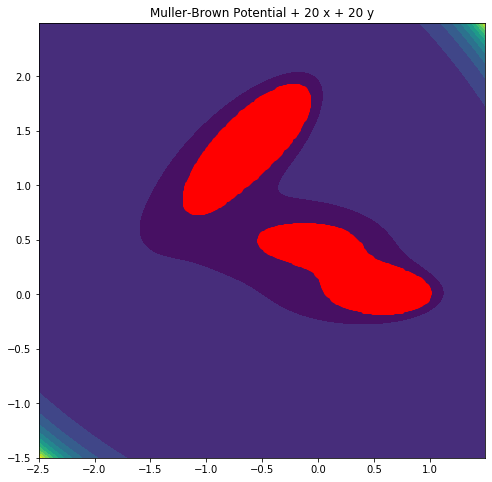

In [12]:
# plot perturb potential 
plt.clf()
fig=plt.figure(figsize=(8,8))
X=np.arange (-2.5,1.5,1/100) ; Y=np.arange(-1.5,2.5,1/100)
X, Y = np.meshgrid(X, Y)
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),perturb=[20,20]))
Z = Z.reshape(X.shape)
ax=fig.add_subplot(111)
ax.contourf(X, Y, Z, 10, linestyles="solid")
ax.set_title('Muller-Brown Potential + 20 x + 20 y')


# compute training set 
dc_index=np.where(Z <-60) # define domain and complement 
d_index=np.where(Z>=-60)
print(np.shape(z_index))
x_dc=X[0][dc_index[1]]
y_dc=Y[:,0][dc_index[0]]
print(np.shape(x_dc)); print(np.shape(y_dc))
x_d=X[0][d_index[1]]
y_d=Y[:,0][d_index[0]]
print(np.shape(x_d)); print(np.shape(y_d))
ax.scatter(x_dc, y_dc, c='r')
d=np.stack((x_d,y_d)).T
dc=np.stack((x_dc,y_dc)).T  

a=dc[np.where(dc[:,0]<0)] # define state a and state b 
a=a[np.where(a[:,1]>a[:,0]+np.full(np.shape(a[:,0]),1.4))]
b=new[np.where(dc[:,0]>-0.8)]
b=new_b[np.where(b[:,1]<b[:,0]+np.full(np.shape(b[:,0]),1.4))]
ax.scatter(a[:,0], a[:,1],c="pink", label="stateA")
ax.scatter(b[:,0], b[:,1],c="orange", label="stateB")

dc_train = np.vstack((a, b)) # define training and target sets for KNN
print(np.shape(dc_train))
train=np.vstack((d,dc_train))
print(np.shape(train))
dc_target = np.vstack((np.full(np.shape(a),1), np.full(np.shape(b),2)))
print(np.shape(dc_target))
target=np.vstack((np.full(np.shape(d),3),dc_target))
print(np.shape(target))
X=np.arange (-2.5,1.5,1/100) ; Y=np.arange(-1.5,2.5,1/100)
X, Y = np.meshgrid(X, Y)
data=np.vstack((X.ravel(),Y.ravel())).T
print(np.shape(data))


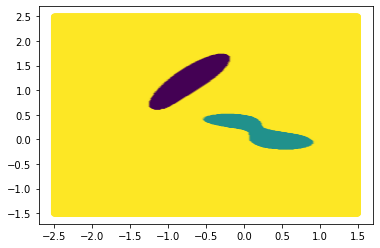

In [7]:
# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 

#use KNN classifier to predict states 
knn = KNeighborsClassifier(n_neighbors=10) 
knn.fit(train,target)
color=knn.predict(data)
# print(np.shape(color))
plt.clf()
plt.scatter(data[:,0], data[:,1],c=color[:,0])


In [9]:
import joblib
joblib.dump(knn,'define_state_for_perturb_MB_potential.joblib')

['define_state_for_perturb_MB_potential.joblib']

In [5]:
# unbiased sampling for DGA with 10,000 trajectories of grid spacing 0.04 with x in [-2.5,1.5] and y in [-1.5,2.5]
coordinates_x=[];
coordinates_y=[];
energies=[];

grid_spacing= 0.04 # this should result in 10,000 trajectories 
for x_min_grid in np.arange(-2.5,1.51-grid_spacing,grid_spacing):
    for y_min_grid in np.arange(-1.5, 2.51-grid_spacing, grid_spacing):
        out=simulate_short_trajectories(x_min_grid, x_min_grid+grid_spacing, y_min_grid, y_min_grid+grid_spacing)
        #coordinates.append([*zip(out[0],out[1])])
        coordinates_x.append(out[0])
        coordinates_y.append(out[1])
        energies.append(out[2])
        

<Figure size 432x288 with 0 Axes>

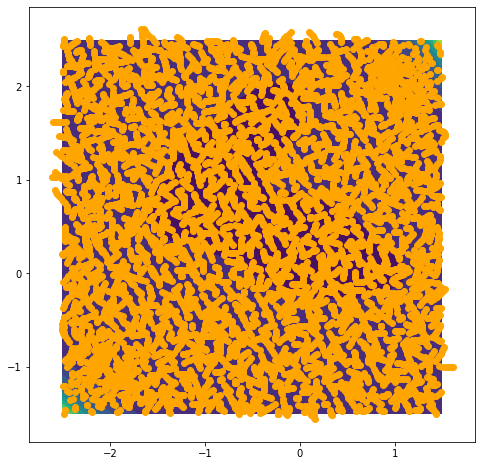

In [142]:
plt.clf()
fig=plt.figure(figsize=(8,8))
X=np.arange (-2.5,1.5,1/100)
Y=np.arange(-1.5,2.5,1/100)
X, Y = np.meshgrid(X, Y)
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y)))
Z = Z.reshape(X.shape)
ax=fig.add_subplot(111)
ax.contourf(X, Y, Z, 10, linestyles="solid")
ax.scatter(coordinates_x[::7],coordinates_y[::7],c="orange")

In [6]:
np.shape(np.asarray(energies))

(10000, 7)

In [132]:
# perturb sampling for DGA with 10,000 trajectories of grid spacing 0.04 with x in [-2.5,1.5] and y in [-1.5,2.5]
# perturb potential is 20x+20y

coordinates_x_p=[];
coordinates_y_p=[];
energies_p=[];

grid_spacing= 0.04 # this should result in 10,000 trajectories 
for x_min_grid in np.arange(-2.5,1.51-grid_spacing,grid_spacing):
    for y_min_grid in np.arange(-1.5, 2.51-grid_spacing, grid_spacing):
        out=simulate_short_trajectories(x_min_grid, x_min_grid+grid_spacing, y_min_grid, y_min_grid+grid_spacing,perturb=[20,20])
        #coordinates.append([*zip(out[0],out[1])])
        coordinates_x_p.append(out[0])
        coordinates_y_p.append(out[1])
        energies_p.append(out[2])

<Figure size 432x288 with 0 Axes>

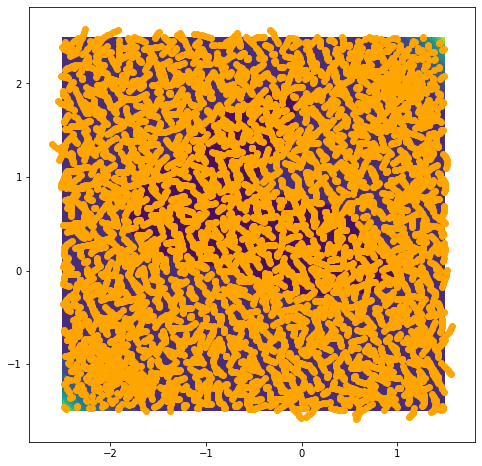

In [140]:
plt.clf()
fig=plt.figure(figsize=(8,8))
X=np.arange (-2.5,1.5,1/100)
Y=np.arange(-1.5,2.5,1/100)
X, Y = np.meshgrid(X, Y)
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y),perturb=[20,20]))
Z = Z.reshape(X.shape)
ax=fig.add_subplot(111)
ax.contourf(X, Y, Z, 10, linestyles="solid")
ax.scatter(coordinates_x_p[::7],coordinates_y_p[::7],c="orange")

Implementing DGA

In [170]:
new=np.stack((coordinates_x,coordinates_y),axis=1) #, coordinates_y
trajs_unbiased=np.ndarray.tolist(np.swapaxes(new, 1, 2))
print(np.shape(trajs_unbiased))
print(type(trajs_unbiased))



(10000, 7, 2)
<class 'list'>


In [29]:
def check_state(y): 
    y=np.asarray(y)
    a=np.empty(shape=np.shape(y))
    b=np.empty(shape=np.shape(y))
    for i in range(np.shape(y)[0]):
        for j in range(np.shape(y)[1]):
            if y[i,j] < 0.15: 
                a[i,j]=1; b[i,j]=0
            elif y[i,j] > 1.15: 
                b[i,j]=1; a[i,j]=0 
            else:
                a[i,j]=0; b[i,j]=0
    return a, b


In [ ]:
import pyedgar

## all of the following are numpy arrays ## 
traj_unperturb = np.load('../data/traj_unperturb.npy') # Raw trajectory
traj_perturb = np.load('../data/traj_perturb.npy')
#compute states
check_state_unperturb=check_state(traj_unperturb[:,:,1])
check_state_perturb=check_state(traj_perturb[:,:,1])
stateA_unperturb=check_state_unperturb[0]
stateB_unperturb=check_state_unperturb[1]
stateA_perturb=check_state_perturb[0]
stateB_perturb=check_state_perturb[1]




diff_atlas = pyedgar.basis.DiffusionAtlas.from_sklearn(alpha=0, k=500, bandwidth_type='-1/d', epsilon='bgh_generous')
diff_atlas.fit(trajs_unbiased)

In [105]:
unperturb_simulation=run_simulate_short_trajectories(-2.5,1.5,-1.5,2.5, n_traj=1000, nsteps_per_trajectory=500,nstxout=100)


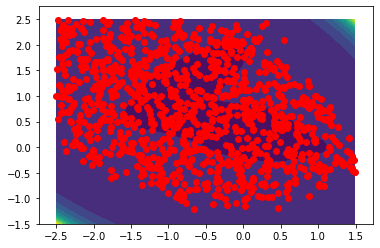

In [110]:
x=unperturb_simulation[0]
y=unperturb_simulation[1]
np.shape(x)
X=np.arange (-2.5,1.5,1/100)
Y=np.arange(-1.5,2.5,1/100)
X, Y = np.meshgrid(X, Y)
Z=np.array(muller_brown_potential(np.ravel(X), np.ravel(Y)))
Z = Z.reshape(X.shape)
plt.contourf(X, Y, Z, 10, linestyles="solid")
plt.scatter(np.transpose(x)[0], np.transpose(y)[0],c='red')
